## EE 347 Lab 2 Data Analysis
Christopher Tinker
2024-04-18

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl

# File I/O and data preprocessing
all_data_dict = pd.read_excel("./ee347-lab2.xlsx", sheet_name=None)

all_data_dict["A"] = all_data_dict["A"].rename(columns={"Power Supply (V) - Plot 0": "Vin", "Agilent Multimeter (V) - Plot 0": "Vout"})
df_nmrl = all_data_dict["A"][["Vin", "Vout", "RL"]]

all_data_dict["B"] = all_data_dict["B"].rename(columns={"Power Supply (V) - Plot 0": "Vin", "Agilent Multimeter (V) - Plot 0": "Vout"})
df_ensat = all_data_dict["B"][["Vin", "Vout"]]

all_data_dict["C"] = all_data_dict["C"].rename(columns={"Power Supply (V) - Plot 0": "Vin", "Agilent Multimeter (V) - Plot 0": "Vout"})
df_pnmos = all_data_dict["C"][["Vin", "Vout"]]

all_data_dict["D"] = all_data_dict["D"].rename(columns={"Power Supply (V) - 5": "Vin", "Agilent Multimeter (V) -5": "Vout",
                                                                             "Vdd – 5": "Vdd"})
df_cmos = all_data_dict["D"][["Vin", "Vout", "Vdd"]]
#all_data_dict["D"]


## VTC Figures of Merit
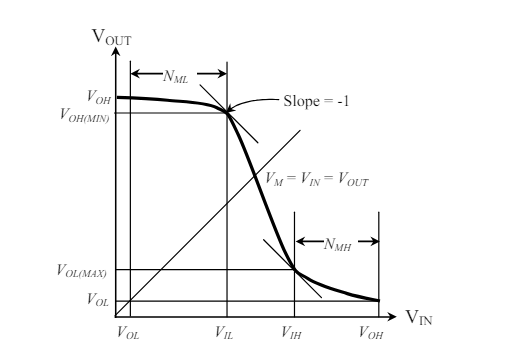

In [2]:
# Useful functions
get_vm_row = lambda df: df.iloc[np.argmin(abs(df["Vout"] - df["Vin"]))]

def calc_vm(df):
    row = df.iloc[np.argmin(abs(df["Vout"] - df["Vin"]))]
    return (row["Vin"] + row["Vout"]) / 2

def vtc_params(df):
    # Metastable Voltage Vm = Vin = Vout (approx)
    vm_row = df.iloc[np.argmin(abs(df["Vout"] - df["Vin"]))]
    vm_vin = vm_row["Vin"].item()
    vm = (vm_row["Vin"] + vm_row["Vout"]) / 2 # approximate with average

    dvin = np.diff(df["Vin"])
    dvout = np.diff(df["Vout"])
    df["Gain"] = [*(dvout / dvin), np.NaN]

    # get critical voltages 
    # there are two pairs of voltages at a gain of -1. Split the VTC
    # in half at the metastable voltage Vm, and separately find 
    # Vin, Vout pairs with Gain closest to -1
    max_gain_idx = df["Gain"].idxmin() # max_gain_idx is a Pandas index, not an array offser
    pre_vm = df.loc[:max_gain_idx] # use .loc not .iloc, as max_gain_idx is a pandas logical index
    post_vm = df.loc[max_gain_idx:]
    idx_low = np.argmin(abs(pre_vm["Gain"] + 1)) # array offset from np.argmin
    idx_high = np.argmin(abs(post_vm["Gain"] + 1)) # array offset from np.argmin
    #print(pre_vm)
    #print(post_vm)
    #print("max gain: ", max_gain_idx)
    #print("idx_low: ", idx_low)
    #print("idx_high: ", idx_high)

    vil = pre_vm.iloc[idx_low]["Vin"].item() # use .iloc as np.argmin returns an array offset (true index)
    voh = pre_vm.iloc[idx_low]["Vout"].item()

    vih = post_vm.iloc[idx_high]["Vin"].item()
    vol = post_vm.iloc[idx_high]["Vout"].item()

    # noise margins
    nmh = voh - vih
    nml = vil - vol
    print("voh vih vm vil vol nmh nml")
    print(voh, vih, vm, vil, vol, nmh, nml, sep="\n") 
    return {"voh": voh, "vih": vih, "vm": vm, "vil": vil, "vol": vol,
            "nmh": nmh, "nml": nml}


### Resistive Load NMOS

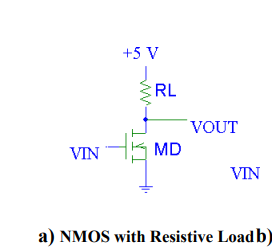

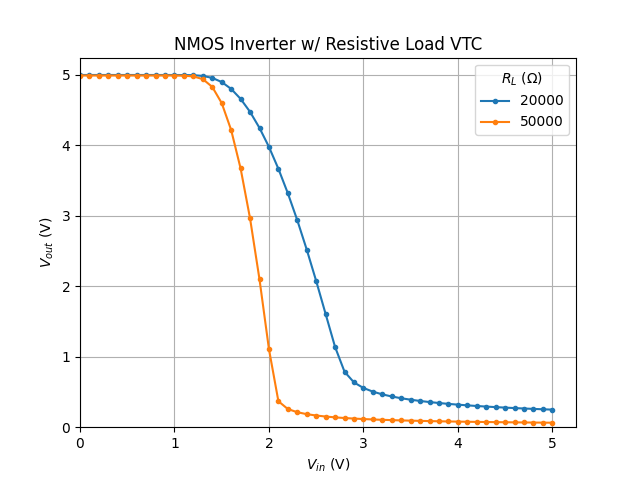

In [3]:
# Graph VTC
plt.figure()
nmrl_rl_group = df_nmrl.groupby("RL")
nmrl_rl_20 = nmrl_rl_group.get_group(20000)
nmrl_rl_50 = nmrl_rl_group.get_group(50000)

for name, group in nmrl_rl_group:
    plt.plot(group["Vin"], group["Vout"], '.-', label=name)

#plt.plot(df_nmrl["Vin"], df_nmrl["Vout"], '.-', label=r"20 $k \Omega$")
#plt.plot(df_nmrl["Vin50"], df_nmrl["Vout50"], '.-', label=r"50 $k \Omega$")

plt.ylabel(r"$V_{out}$ (V)")
plt.xlabel(r"$V_{in}$ (V)")
plt.title(r"NMOS Inverter w/ Resistive Load VTC")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid()
plt.legend(title=r"$R_L$ ($\Omega$)")
plt.show()

In [4]:
# Calculations for RL = 20k
vm = calc_vm(nmrl_rl_20)
vil = 1.4
vih = 2.8
vol = nmrl_rl_20[nmrl_rl_20["Vin"] == vih]["Vout"].item()
voh = nmrl_rl_20[nmrl_rl_20["Vin"] == vil]["Vout"].item()

nmh = voh - vih
nml = vil - vol
print(voh, vih, vm, vil, vol, nmh, nml, sep="\n")

4.9547
2.8
2.4594
1.4
0.7868
2.1547
0.6131999999999999


In [5]:
# calculations for RL = 50k
vm = calc_vm(nmrl_rl_50)
vil = 1.3
vih = 2.1
vol = nmrl_rl_50[nmrl_rl_50["Vin"] == vih]["Vout"].item()
voh = nmrl_rl_50[nmrl_rl_50["Vin"] == vil]["Vout"].item()

nmh = voh - vih
nml = vil - vol
print(voh, vih, vm, vil, vol, nmh, nml, sep="\n")
#type(vol)

4.9371
2.1
1.9981
1.3
0.3681
2.8371
0.9319000000000001


### Saturated ENMOS Load

In [6]:
params = vtc_params(df_ensat)

voh vih vm vil vol nmh nml
1.7818
2.3
1.6381999999999999
1.5
0.4516
-0.5181999999999998
1.0484


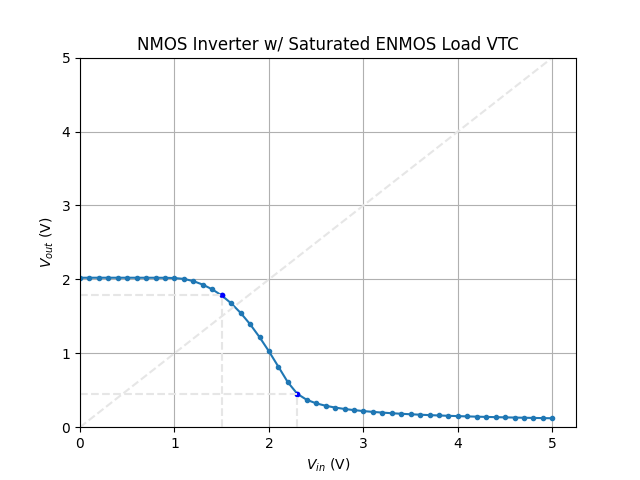

In [7]:
plt.figure()
plt.plot(df_ensat["Vin"], df_ensat["Vout"], '.-')
plt.ylabel(r"$V_{out}$ (V)")
plt.xlabel(r"$V_{in}$ (V)")
plt.title(r"NMOS Inverter w/ Saturated ENMOS Load VTC")
plt.xlim(left=0)
plt.ylim([0, 5])
plt.grid()

plt.plot(params["vil"], params["voh"], 'b.')
plt.plot(params["vih"], params["vol"], 'b.')
plt.axvline(params["vil"], 0, params["voh"] / plt.ylim()[1], color='0.9', linestyle='--')
plt.axhline(params["voh"], 0, params["vil"]/ plt.xlim()[1], color='0.9', linestyle='--')

plt.axvline(params["vih"], 0, params["vol"] / plt.ylim()[1], color='0.9', linestyle='--')
plt.axhline(params["vol"], 0, params["vih"] / plt.xlim()[1], color='0.9', linestyle='--')

plt.axline((0,0), (params["vm"], params["vm"]), color='0.9', linestyle='--')
plt.show()

### Pseudo NMOS

In [8]:
pnmos_vin_group = df_pnmos.groupby("Vin")
df_pnmos_avgd = pnmos_vin_group.mean()
df_pnmos_avgd = df_pnmos_avgd.reset_index() # .mean() turns Vin into indices, not a column


In [9]:
params = vtc_params(df_pnmos_avgd)

voh vih vm vil vol nmh nml
4.85225
2.2
1.6773500000000001
1.7
0.3387
2.6522499999999996
1.3613


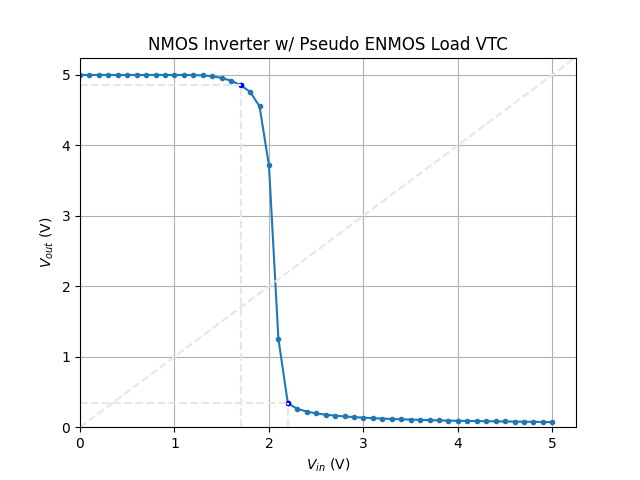

In [10]:
plt.figure()
plt.plot(df_pnmos_avgd["Vin"], df_pnmos_avgd["Vout"], '.-')
plt.ylabel(r"$V_{out}$ (V)")
plt.xlabel(r"$V_{in}$ (V)")
plt.title(r"NMOS Inverter w/ Pseudo ENMOS Load VTC")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid()

plt.plot(params["vil"], params["voh"], 'b.')
plt.plot(params["vih"], params["vol"], 'b.')
plt.axvline(params["vil"], 0, params["voh"] / plt.ylim()[1], color='0.9', linestyle='--')
plt.axhline(params["voh"], 0, params["vil"]/ plt.xlim()[1], color='0.9', linestyle='--')

plt.axvline(params["vih"], 0, params["vol"] / plt.ylim()[1], color='0.9', linestyle='--')
plt.axhline(params["vol"], 0, params["vih"] / plt.xlim()[1], color='0.9', linestyle='--')

plt.axline((0,0), (params["vm"], params["vm"]), color='0.9', linestyle='--')

plt.show()

### CMOS Inverter

In [11]:
#df_cmos.head()

In [12]:
# Sweep-n-go took multiple samples at each Vin step. Group data by 
# unique Vin and Vdd value, find the mean Vout for each Vin for each Vdd, and graph the 
# resulting data
cmos_vin_group = df_cmos.groupby(["Vin", "Vdd"])
df_cmos_avgd = cmos_vin_group.mean()
df_cmos_avgd = df_cmos_avgd.reset_index() # .mean() turns Vin into indices, not a column
df_cmos_avgd

,Vin,Vdd,Vout
0,0.0,5,4.99750
1,0.0,10,9.99910
2,0.1,5,4.99756
3,0.1,10,9.99910
4,0.2,5,4.99760
...,...,...,...
147,9.6,10,0.00000
148,9.7,10,0.00000
149,9.8,10,0.00000
150,9.9,10,0.00000


In [13]:
cmos_vdd_group = df_cmos_avgd.groupby("Vdd")
cmos_vdd_10 = cmos_vdd_group.get_group(10)
params = vtc_params(cmos_vdd_10)

voh vih vm vil vol nmh nml
9.0994
5.5
4.9376
3.7
1.1367
3.5993999999999993
2.5633


C:\Users\chris\AppData\Local\Temp\ipykernel_10336\181037888.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Gain"] = [*(dvout / dvin), np.NaN]


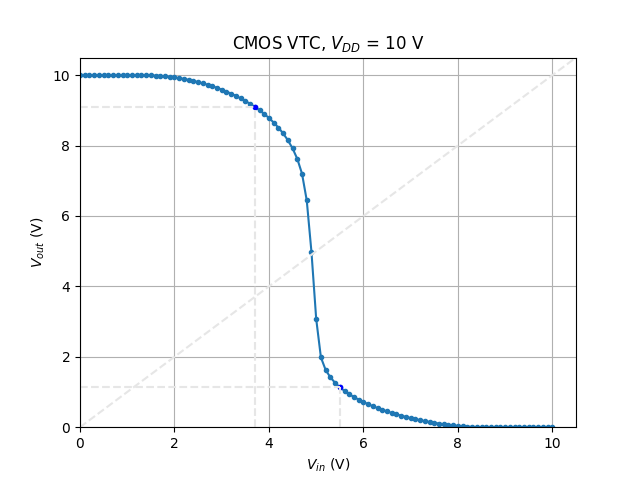

In [14]:

plt.figure()
# for name, group in cmos_vdd_group:
#     plt.plot(group["Vin"], group["Vout"], '.-', label=name)
plt.plot(cmos_vdd_10["Vin"], cmos_vdd_10["Vout"], '.-')

plt.ylabel(r"$V_{out}$ (V)")
plt.xlabel(r"$V_{in}$ (V)")
plt.title(r"CMOS VTC, $V_{DD}$ = 10 V")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid()
#plt.legend(title=r"$V_{DD}$")

plt.plot(params["vil"], params["voh"], 'b.')
plt.plot(params["vih"], params["vol"], 'b.')
plt.axvline(params["vil"], 0, params["voh"] / plt.ylim()[1], color='0.9', linestyle='--')
plt.axhline(params["voh"], 0, params["vil"]/ plt.xlim()[1], color='0.9', linestyle='--')

plt.axvline(params["vih"], 0, params["vol"] / plt.ylim()[1], color='0.9', linestyle='--')
plt.axhline(params["vol"], 0, params["vih"] / plt.xlim()[1], color='0.9', linestyle='--')

plt.axline((0,0), (params["vm"], params["vm"]), color='0.9', linestyle='--')
plt.show()

In [15]:
cmos_vdd_5 = cmos_vdd_group.get_group(5)
params = vtc_params(cmos_vdd_5)

voh vih vm vil vol nmh nml
4.8040400000000005
2.6
2.78218
2.0
0.31028
2.2040400000000004
1.6897199999999999


C:\Users\chris\AppData\Local\Temp\ipykernel_10336\181037888.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Gain"] = [*(dvout / dvin), np.NaN]


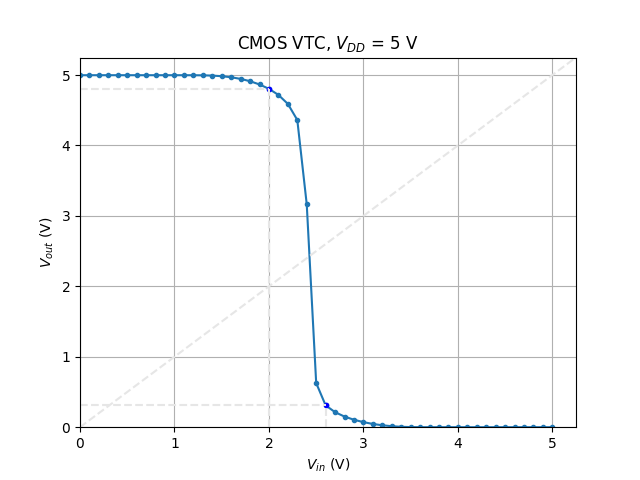

In [16]:
plt.figure()
plt.plot(cmos_vdd_5["Vin"], cmos_vdd_5["Vout"], '.-')
plt.ylabel(r"$V_{out}$ (V)")
plt.xlabel(r"$V_{in}$ (V)")
plt.title(r"CMOS VTC, $V_{DD}$ = 5 V")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid()
#plt.legend(title=r"$V_{DD}$")

plt.plot(params["vil"], params["voh"], 'b.')
plt.plot(params["vih"], params["vol"], 'b.')
plt.axvline(params["vil"], 0, params["voh"] / plt.ylim()[1], color='0.9', linestyle='--')
plt.axhline(params["voh"], 0, params["vil"]/ plt.xlim()[1], color='0.9', linestyle='--')

plt.axvline(params["vih"], 0, params["vol"] / plt.ylim()[1], color='0.9', linestyle='--')
plt.axhline(params["vol"], 0, params["vih"] / plt.xlim()[1], color='0.9', linestyle='--')

plt.axline((0,0), (params["vm"], params["vm"]), color='0.9', linestyle='--')

plt.show()

### All VTC

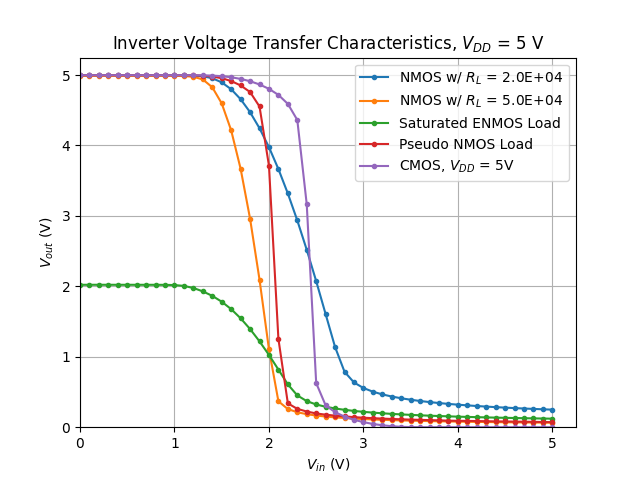

In [17]:
plt.figure()
#plt.plot(df_nmrl["Vin"], df_nmrl["Vout"], '.-', label="NMOS w/ Resistive Load")
for name, group in nmrl_rl_group:
    plt.plot(group["Vin"], group["Vout"], '.-', label="NMOS w/ $R_L$ = {:.1E}".format(name))
plt.plot(df_ensat["Vin"], df_ensat["Vout"], '.-', label="Saturated ENMOS Load")
plt.plot(df_pnmos_avgd["Vin"], df_pnmos_avgd["Vout"], '.-', label="Pseudo NMOS Load")
plt.plot(cmos_vdd_5["Vin"], cmos_vdd_5["Vout"], '.-', label="CMOS, $V_{DD}$ = 5V")

plt.ylabel(r"$V_{out}$ (V)")
plt.xlabel(r"$V_{in}$ (V)")
plt.title(r"Inverter Voltage Transfer Characteristics, $V_{DD}$ = 5 V")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid()
plt.legend(loc='upper right')
plt.show()